In [ ]:
# !pip install torchmetrics 

In [ ]:
! pip install -q kaggle
from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# !kaggle datasets download bulentsiyah/semantic-drone-dataset -p /content/sample_data/ --unzip

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

# !pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
IMAGE_PATH = '../content/sample_data/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../content/sample_data/dataset/semantic_drone_dataset/label_images_semantic/'

In [ ]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [ ]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


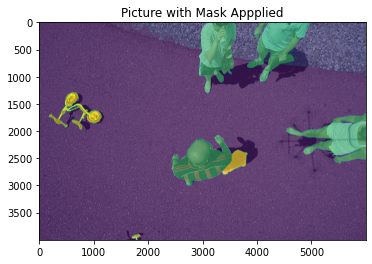

In [ ]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [ ]:
class DroneDataset(Dataset):

  def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
    self.img_path = img_path
    self.mask_path = mask_path
    self.X = X
    self.transform = transform
    self.patches = patch
    self.mean = mean
    self.std = std
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

In [ ]:
# t_find = A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST)
# find_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_find, patch=False)

# count_colors = [0] 
# count_colors *= 23

# for i in range(306):
#     # print(count_colors)
#     _ , mask = find_set[i]
#     import numpy
#     np_mask = mask.numpy()

#     unique, counts = numpy.unique(np_mask, return_counts=True)
#     print(unique)
#     print(counts)
#     for j, i in enumerate(unique):
#         count_colors[i] += counts[j]

[ 0  1  2  3  4  8 10 13 15 19 21 22]
[  1555  72734  34600 403917  15766  95600   2961  12318  15321  62899
   3505  22248]
[ 0  1  2  4  6  8  9 10 11 15 18 22]
[  1367 148050  47760   6164    402  93678 431353    118   9835   2226
    334   2137]
[ 0  1  2  3  4  6  8  9 10 13 14 15 17 18 19 22]
[  1682 485416  18211  23201  29518   5680  70909    740  16434  14001
    540   1176  29651    499  11227  34539]
[ 0  1  2  4  5  6  8 10 13 14 15 19 21 22]
[  1478 207762  31943  69752 170249  89566  88437   6270   6333   2168
   8559  43817  12376   4714]


KeyboardInterrupt: ignored

In [ ]:
x = torch.randint(0, 2, (5, ))
y = torch.randn(5)
print(x)
print(y)
print(x * y)

tensor([0, 0, 0, 0, 1])
tensor([ 0.1280, -0.7323, -0.2530,  0.9958, -2.0856])
tensor([ 0.0000, -0.0000, -0.0000,  0.0000, -2.0856])


In [ ]:
# x = [0] * 23
# for i in range(1, 23):
#     x[i] = x[i - 1] + 1

In [ ]:
# plt.plot(x, count_colors)

In [ ]:
list_of_colors = []

In [ ]:
# for j, i in enumerate(count_colors):
#     if i/sum(count_colors) < 0.005:
#         list_of_colors.append(j)
#         print(j)
#     # print(i)
#     # print(i/sum(count_colors))

In [ ]:
list_of_colors = [0, 12, 14, 16, 18, 21]
weights = []
for i in range(23):
    if (i in list_of_colors):
        weights.append(5.0)
    else:
        weights.append(1.0)
    # for j in list_of_colors:
    #     if i == j:
    #         weights.append(5.0)
    #         continue
    # weights.append(1.0)

class_weights = torch.FloatTensor(weights).cuda()

In [ ]:
print(weights)

[5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 5.0, 1.0, 5.0, 1.0, 5.0, 1.0, 1.0, 5.0, 1.0]


In [ ]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down1 = self.down_block(in_channels, 64, 7, 3)
        self.down2 = self.down_block(64, 128, 3, 1)
        self.down3 = self.down_block(128, 256,  3, 1)
        self.down4 = self.down_block(256, 512,  3, 1)
        self.down5 = self.down_block(512, 1024, 3, 1)

        self.last = self.down_block(128, 64, 3, 1)
        self.last1 = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        

        self.upconv5 = self.expand_block(1024, 512, 3, 1)
        # self.upconv4 = self.expand_block(512 * 2, 256, 3, 1)
        self.upconv4 = self.expand_block(512, 256, 3, 1)

        self.upconv3 = self.expand_block(256 * 2, 128, 3, 1)
        # self.upconv3 = self.expand_block(256, 128, 3, 1)

        self.upconv2 = self.expand_block(128 * 2, 64, 3, 1)

      
    def down_block(self, in_channels, out_channels, kernel_size, padding):
        down = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
        )
        return down

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

    def forward(self, x):
        # downsampling part
        conv1 = self.down1(x)
        conv2 = self.down2(self.pool(conv1))
        conv3 = self.down3(self.pool(conv2))
        conv4 = self.down4(self.pool(conv3))
        # conv5 = self.down5(self.pool(conv4))

        # upconv5 = self.upconv5(conv5)
        # upconv4 = self.upconv4(torch.cat([upconv5, conv4], 1))
        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.last1(self.last(torch.cat([upconv2, conv1], 1)))
        return upconv1 

In [ ]:
model = UNET(3, 23)
optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights)

epochs = 15

In [ ]:
print(error)

NameError: ignored

In [ ]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y) 

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}   AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model.pt')
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


In [ ]:
import torch
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/1024/1024)

In [ ]:
checkpoint = torch.load('model20ep.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.cuda()

In [ ]:
all_colors = [0] 
all_colors *= 24
correct_colors = [0]
correct_colors *= 24

for x, y in val_loader:
    x = x.cuda()
    y = y.cuda()
    model.cuda()
    # print(x.shape)
    # print(y.shape)

    with torch.no_grad():
        output = model(x)
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        output += 1
        y += 1
        correct = torch.eq(output, y).int()
        correct = correct.cuda()
        output = output * correct
        y = y.cpu()
        np_y = y.numpy()
        unique_y, counts_y = np.unique(np_y, return_counts=True)
        
        output = output.cpu()
        np_output = output.numpy()
        unique_output, counts_output = np.unique(np_output, return_counts=True)
        # print(unique)
        # print(counts)
        for j, i in enumerate(unique_y):
            all_colors[i] += counts_y[j]

        for j, i in enumerate(unique_output):
            correct_colors[i] += counts_output[j]

In [ ]:
print(all_colors)
print(correct_colors)

[0, 103281, 16453955, 1069160, 6437665, 3061902, 653733, 214417, 466773, 2932949, 3666756, 1053558, 85508, 21446, 275236, 11236, 449616, 6650, 373172, 107937, 391263, 628634, 61851, 1618198]
[14093407, 37117, 14127084, 335595, 5839575, 1611995, 199602, 0, 147845, 1574239, 1800602, 14889, 0, 0, 0, 0, 104825, 0, 11025, 0, 40, 0, 1417, 245639]


In [ ]:
for i in range(1, 23):
    print(correct_colors[i] / all_colors[i])

0.3772776090659951
0.8825750800662804
0.3210204284822099
0.8364066554700791
0.5435387394994897
0.2376010164878178
0.0
0.3662007408114964
0.5322438425982405
0.4941624982815326
0.01889124066517469
0.0
0.0
0.0
0.0
0.22945942901817362
0.0
0.025470190007188302
0.0
0.00034902744955462645
0.0
0.0360062893081761


In [ ]:
print(all_colors)
print(correct_colors)


[0, 108008, 16297435, 1104830, 6446607, 3164251, 664248, 210849, 471105, 2950920, 3593318, 1087594, 85725, 21760, 275525, 10953, 452799, 7067, 372828, 103048, 412575, 593417, 63600, 1646434]
[14181127, 40749, 14383710, 354673, 5391985, 1719893, 157826, 0, 172519, 1570609, 1775683, 20546, 0, 0, 0, 0, 103899, 0, 9496, 0, 144, 0, 2290, 259747]


In [ ]:
# from sklearn.metrics import classification_report
# for x, y in train_loader:
#     model.cuda()
#     x = x.cuda()
#     x = y.cuda()
#     output = model(x)
#         # output = torch.randn(10, 3, 10)
#         # mask = torch.randint(0, 3, (10, 10))
#         # print(output.shape)

#     output = torch.argmax(F.softmax(output, dim=1), dim=1)
#     print(output.shape)
#         # print(mask)

#         # print(classification_report(y, output))


In [ ]:
# import torchmetrics
# confmat = torchmetrics.ConfusionMatrix(num_classes=23, 
#                                        multilabel=True, 
#                                        normalize='true')
# for x, y in train_loader:
#     x = x.cuda()
#     y = y.cuda()
#     model.cuda()
#     outputs = model(x)
#     print(outputs.shape)
    # preds = F.softmax(outputs)
    # output = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    # confmat(preds, y)

In [ ]:
# print(output.shape)
# print(y.shape)

In [ ]:
train_loss, valid_loss = train(model, train_loader, val_loader, criterion, optimizer, pixel_accuracy, epochs=50)
# fit()

In [ ]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

In [ ]:
image, mask = test_set[1]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()

In [ ]:
image, mask = test_set[2]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()

In [ ]:
image, mask = test_set[0]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()